# NIJs Recidivism

In this project, KMeans clustering was applied as an unsupervised learning approach to group individuals in the NIJ Recidivism dataset based on demographic, employment, and criminal history features. The goal of clustering was to identify latent patterns among individuals without using recidivism outcomes as labels, allowing the data itself to reveal groups with similar characteristics. This unsupervised approach is appropriate because it does not rely on pre-defined outcomes, and it can uncover meaningful profiles that might inform targeted interventions or rehabilitation strategies.

### Citation
National Institute of Justice. (2021). NIJ’s Recidivism Challenge Full Dataset [Dataset]. Office of Justice Programs, U.S. Department of Justice. Retrieved from https://catalog.data.gov/dataset/nijs-recidivism-challenge-full-dataset

### Set-Up

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

sns.set(style="whitegrid")

## EDA

Initial data exploration revealed a mix of numeric and categorical features with varying levels of missing data. Numeric variables such as Percent_Days_Employed, Jobs_Per_Year, and Age_at_Release were cleaned by converting text ranges and categories into numeric representations and filling missing values with the median. Categorical features, including Gender and Race, were one-hot encoded. Distributional analysis showed that most individuals were male, aged between 30 and 35 at release, and racially diverse. Employment levels varied widely, from near-zero employment to full employment, while supervision risk scores were generally moderate to high. Correlation analysis indicated that employment metrics were negatively correlated with recidivism, while risk scores were slightly positively correlated. Standard scaling was applied to numeric features in preparation for PCA and clustering.

In [2]:
df = pd.read_csv('NIJ_s_Recidivism_Challenge_Full_Dataset.csv')

df.head()


,ID,Gender,Race,Age_at_Release,Residence_PUMA,Gang_Affiliated,Supervision_Risk_Score_First,Supervision_Level_First,Education_Level,Dependents,...,DrugTests_Meth_Positive,DrugTests_Other_Positive,Percent_Days_Employed,Jobs_Per_Year,Employment_Exempt,Recidivism_Within_3years,Recidivism_Arrest_Year1,Recidivism_Arrest_Year2,Recidivism_Arrest_Year3,Training_Sample
0,1,M,BLACK,43-47,16,False,3.0,Standard,At least some college,3 or more,...,0.000000,0.0,0.488562,0.447610,False,False,False,False,False,1
1,2,M,BLACK,33-37,16,False,6.0,Specialized,Less than HS diploma,1,...,0.000000,0.0,0.425234,2.000000,False,True,False,False,True,1
2,3,M,BLACK,48 or older,24,False,7.0,High,At least some college,3 or more,...,0.166667,0.0,0.000000,0.000000,False,True,False,True,False,1
3,4,M,WHITE,38-42,16,False,7.0,High,Less than HS diploma,1,...,0.000000,0.0,1.000000,0.718996,False,False,False,False,False,1
4,5,M,WHITE,33-37,16,False,4.0,Specialized,Less than HS diploma,3 or more,...,0.058824,0.0,0.203562,0.929389,False,True,True,False,False,1


In [3]:
df.info()

df.describe()

df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25835 entries, 0 to 25834
Data columns (total 54 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   ID                                                 25835 non-null  int64  
 1   Gender                                             25835 non-null  object 
 2   Race                                               25835 non-null  object 
 3   Age_at_Release                                     25835 non-null  object 
 4   Residence_PUMA                                     25835 non-null  int64  
 5   Gang_Affiliated                                    22668 non-null  object 
 6   Supervision_Risk_Score_First                       25360 non-null  float64
 7   Supervision_Level_First                            24115 non-null  object 
 8   Education_Level                                    25835 non-null  object 
 9   Depend

ID                                                      0
Gender                                                  0
Race                                                    0
Age_at_Release                                          0
Residence_PUMA                                          0
Gang_Affiliated                                      3167
Supervision_Risk_Score_First                          475
Supervision_Level_First                              1720
Education_Level                                         0
Dependents                                              0
Prison_Offense                                       3277
Prison_Years                                            0
Prior_Arrest_Episodes_Felony                            0
Prior_Arrest_Episodes_Misd                              0
Prior_Arrest_Episodes_Violent                           0
Prior_Arrest_Episodes_Property                          0
Prior_Arrest_Episodes_Drug                              0
Prior_Arrest_E

In [4]:
# unique values in these columns
for col in ['Dependents', 'Jobs_Per_Year']:
    print(col, df[col].unique())
def convert_to_numeric(x):
    if pd.isnull(x):
        return np.nan
    elif isinstance(x, str) and 'or more' in x:
        return float(x.split()[0])  # take the first number
    else:
        return float(x)

df['Dependents_numeric'] = df['Dependents'].apply(convert_to_numeric)
df['Jobs_Per_Year_numeric'] = df['Jobs_Per_Year'].apply(convert_to_numeric)

Dependents ['3 or more' '1' '0' '2']
Jobs_Per_Year [0.44761029 2.         0.         ... 0.2818287  1.37484316 1.33465286]


In [5]:
# convert ranges to midpoint
def range_to_midpoint(x):
    if isinstance(x, str) and '-' in x:
        start, end = x.split('-')
        return (float(start) + float(end)) / 2
    else:
        return np.nan

df['Age_at_Release_numeric'] = df['Age_at_Release'].apply(range_to_midpoint)

## Visualize

Exploratory visualization confirmed these patterns: Histograms of age, supervision risk scores, and employment showed diverse distributions, while countplots revealed gender and race breakdowns. A PCA projection provided a preliminary view of feature relationships in two-dimensional space, facilitating the subsequent clustering analysis.

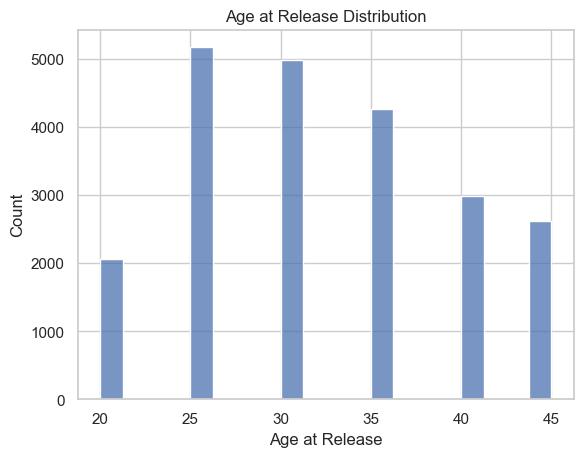

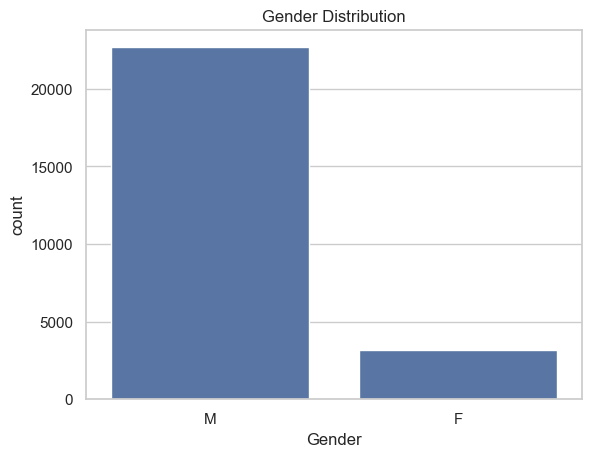

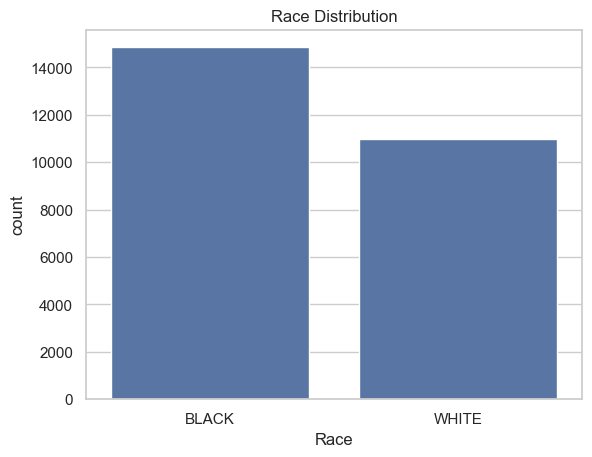

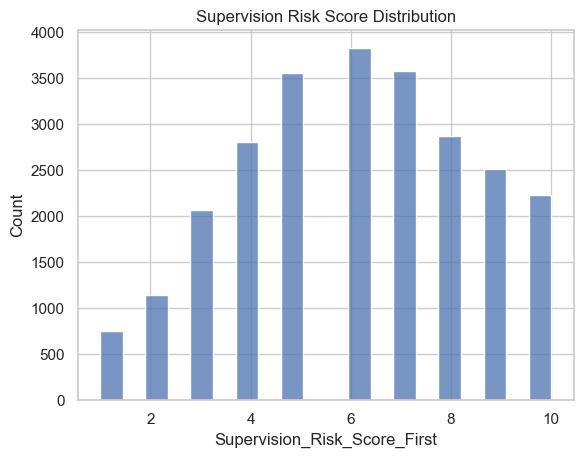

In [6]:
# Age distribution
sns.histplot(df['Age_at_Release_numeric'], bins=20)
plt.xlabel("Age at Release")
plt.title("Age at Release Distribution")
plt.show()


# Gender distribution
sns.countplot(x='Gender', data=df)
plt.title("Gender Distribution")
plt.show()

# Race distribution
sns.countplot(x='Race', data=df)
plt.title("Race Distribution")
plt.show()

# Supervision risk score
sns.histplot(df['Supervision_Risk_Score_First'], bins=20)
plt.title("Supervision Risk Score Distribution")
plt.show()


In [7]:
# Replace numeric_features
numeric_features = [
    'Age_at_Release_numeric',
    'Supervision_Risk_Score_First',
    'Dependents_numeric',
    'Percent_Days_Employed',
    'Jobs_Per_Year_numeric'
]

# Fill missing values
df[numeric_features] = df[numeric_features].fillna(df[numeric_features].median())

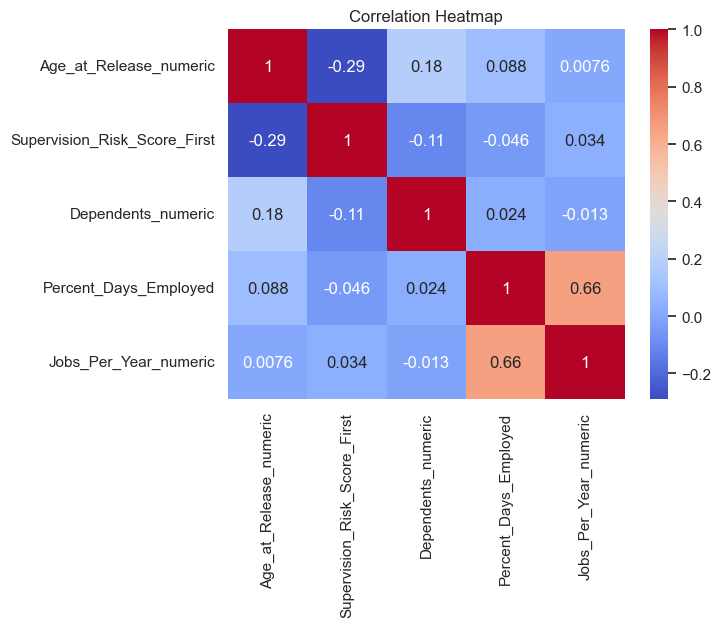

In [8]:
# Correlation heatmap
corr = df[numeric_features].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


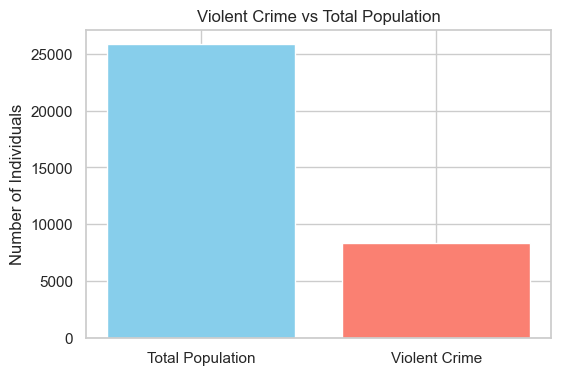

In [9]:
total_count = len(df)

# Count individuals with prior violent convictions
violent_count = df['Prior_Conviction_Episodes_Viol'].sum()

labels = ['Total Population', 'Violent Crime']
counts = [total_count, violent_count]

# Plot
plt.figure(figsize=(6,4))
plt.bar(labels, counts, color=['skyblue', 'salmon'])
plt.ylabel('Number of Individuals')
plt.title('Violent Crime vs Total Population')
plt.show()

In [10]:
# Fill missing numeric values with median
df[numeric_features] = df[numeric_features].fillna(df[numeric_features].median())

categorical_features = ['Race', 'Gender']
df_encoded = pd.get_dummies(df[categorical_features], drop_first=True)


# Combine numeric + encoded categorical features
X = pd.concat([df[numeric_features], df_encoded], axis=1)

# Scale data for clustering/PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


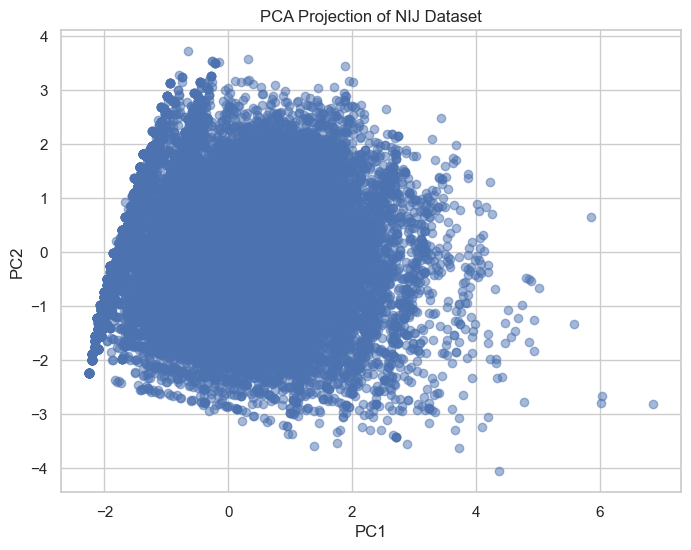

In [11]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], alpha=0.5)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Projection of NIJ Dataset')
plt.show()


## KMeans

KMeans clustering was performed on scaled numeric and encoded categorical features, with the optimal number of clusters determined via silhouette analysis as four. Clusters were profiled based on age, risk score, dependents, employment, and jobs per year.

The results revealed distinct patterns: one cluster with very low employment exhibited the highest recidivism rate (71%), whereas clusters with higher employment had lower recidivism rates (45–53%). PCA visualization confirmed that the clusters were separable in two-dimensional space. Cluster labeling based on employment and risk levels provided interpretable insights, suggesting that employment is a critical protective factor against recidivism and that low-employment individuals represent a high-risk group.

C:\Users\asm3886\anaconda3\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


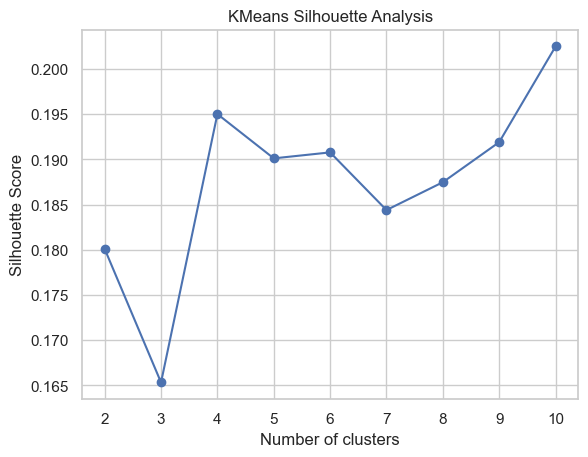

In [12]:
# Determine optimal number of clusters
sil_scores = []
K_range = range(2, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    sil_scores.append(silhouette_score(X_scaled, labels))

# silhouette scores
plt.plot(K_range, sil_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('KMeans Silhouette Analysis')
plt.show()


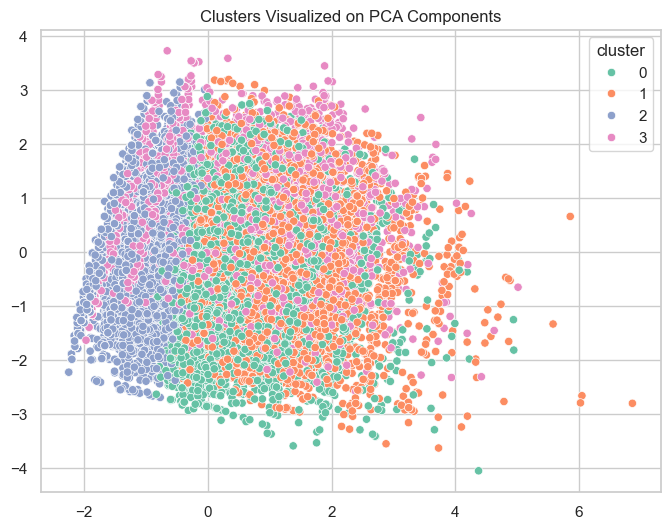

In [13]:
# Fit KMeans
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X_scaled)
df['cluster'] = clusters

# Cluster in PCA space
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df['cluster'], palette='Set2')
plt.title('Clusters Visualized on PCA Components')
plt.show()


In [14]:
# mean of numeric features
cluster_summary = df.groupby('cluster')[numeric_features].mean()

# mean recidivism rate
recidivism_rate = df.groupby('cluster')['Recidivism_Within_3years'].mean()

# Combine summaries
cluster_info = cluster_summary.copy()
cluster_info['Recidivism_Rate'] = recidivism_rate

print(cluster_info)

         Age_at_Release_numeric  Supervision_Risk_Score_First  \
cluster                                                         
0                     31.712495                      6.012110   
1                     32.792531                      5.877510   
2                     30.568253                      6.263661   
3                     33.074250                      6.063191   

         Dependents_numeric  Percent_Days_Employed  Jobs_Per_Year_numeric  \
cluster                                                                     
0                  1.647386               0.807555               1.182983   
1                  1.335934               0.794549               1.242640   
2                  1.398816               0.045885               0.167190   
3                  1.558294               0.493171               0.747794   

         Recidivism_Rate  
cluster                   
0               0.488389  
1               0.527303  
2               0.712445  
3          

In [15]:
def name_cluster(row):
    # Risk level
    if row['Recidivism_Rate'] > 0.50:
        risk = "High-Risk"
    elif row['Recidivism_Rate'] > 0.2:
        risk = "Moderate-Risk"
    else:
        risk = "Lower-Risk"
    
    # Employment descriptor
    emp = row['Percent_Days_Employed']
    if emp > 0.7:
        emp_label = "High Employment"
    elif emp > 0.4:
        emp_label = "Partial Employment"
    else:
        emp_label = "Low Employment"
    
    return f"{risk} / {emp_label}"

In [16]:
# Create a mapping from cluster number → name
cluster_names = cluster_info.apply(name_cluster, axis=1).to_dict()

# Map
df['cluster_name'] = df['cluster'].map(cluster_names)

# Preview
df[['cluster', 'cluster_name']].drop_duplicates()

,cluster,cluster_name
0,0,Moderate-Risk / High Employment
2,2,High-Risk / Low Employment
3,1,High-Risk / High Employment
8,3,Moderate-Risk / Partial Employment


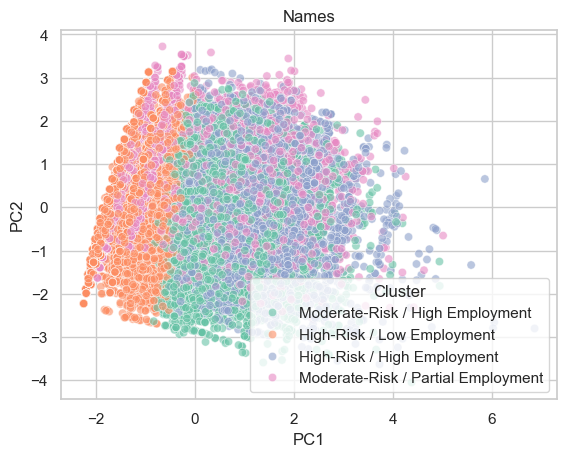

In [17]:
sns.scatterplot(
    x=X_pca[:,0],
    y=X_pca[:,1],
    hue=df['cluster_name'],
    palette='Set2',
    alpha=0.6
)
plt.title('Names')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title='Cluster')
plt.show()


In [18]:
# cluster profiles
cluster_summary = df.groupby('cluster')[numeric_features].mean()
print(cluster_summary)

# Compare recidivism rates
recidivism_rate_by_cluster = df.groupby('cluster')['Recidivism_Within_3years'].mean()
print(recidivism_rate_by_cluster)


         Age_at_Release_numeric  Supervision_Risk_Score_First  \
cluster                                                         
0                     31.712495                      6.012110   
1                     32.792531                      5.877510   
2                     30.568253                      6.263661   
3                     33.074250                      6.063191   

         Dependents_numeric  Percent_Days_Employed  Jobs_Per_Year_numeric  
cluster                                                                    
0                  1.647386               0.807555               1.182983  
1                  1.335934               0.794549               1.242640  
2                  1.398816               0.045885               0.167190  
3                  1.558294               0.493171               0.747794  
cluster
0    0.488389
1    0.527303
2    0.712445
3    0.455292
Name: Recidivism_Within_3years, dtype: float64


In [19]:
recid_cols = ['Recidivism_Arrest_Year1', 'Recidivism_Arrest_Year2', 'Recidivism_Arrest_Year3']

# Melt the dataframe
df_long = df.melt(
    id_vars=['ID', 'Percent_Days_Employed'],  # keep ID and employment
    value_vars=recid_cols,
    var_name='Year',
    value_name='Recidivism'
)

# 'Year' to numeric 1,2,3
df_long['Year'] = df_long['Year'].str.extract(r'(\d)').astype(int)


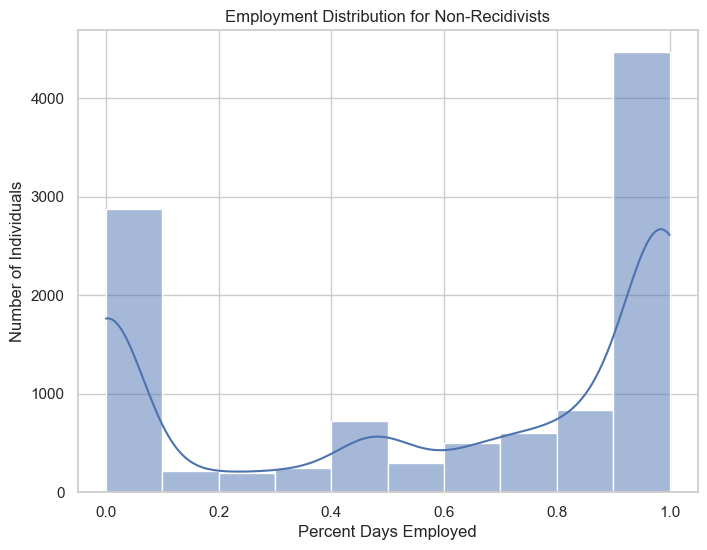

C:\Users\asm3886\AppData\Local\Temp\ipykernel_10708\1606978834.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_recid['Employment_Level'] = pd.cut(


In [20]:
# Select only individuals who did NOT reoffend within 3 years
df_no_recid = df[df['Recidivism_Within_3years'] == False]

# Employment distribution
plt.figure(figsize=(8,6))
sns.histplot(df_no_recid['Percent_Days_Employed'], bins=10, kde=True)
plt.xlabel('Percent Days Employed')
plt.ylabel('Number of Individuals')
plt.title('Employment Distribution for Non-Recidivists')
plt.show()

# Categorize employment levels
df_no_recid['Employment_Level'] = pd.cut(
    df_no_recid['Percent_Days_Employed'],
    bins=[-0.01, 0.4, 0.7, 1],
    labels=['Low','Partial','High']
)

C:\Users\asm3886\AppData\Local\Temp\ipykernel_10708\334640896.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_mean = df_long.groupby(['Year', pd.cut(df_long['Percent_Days_Employed'], bins=[-0.01,0.4,0.7,1], labels=['Low','Partial','High'])])['Recidivism'].mean().reset_index()


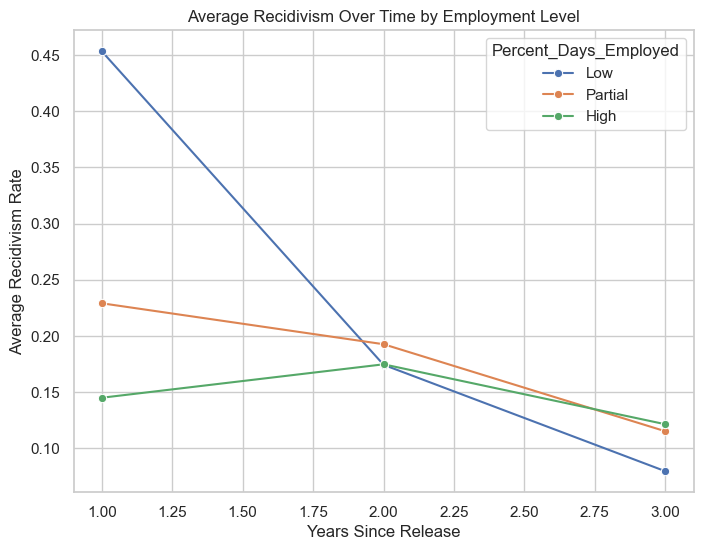

In [21]:
df_mean = df_long.groupby(['Year', pd.cut(df_long['Percent_Days_Employed'], bins=[-0.01,0.4,0.7,1], labels=['Low','Partial','High'])])['Recidivism'].mean().reset_index()

plt.figure(figsize=(8,6))
sns.lineplot(
    x='Year',
    y='Recidivism',
    hue='Percent_Days_Employed',
    data=df_mean,
    marker='o'
)
plt.xlabel('Years Since Release')
plt.ylabel('Average Recidivism Rate')
plt.title('Average Recidivism Over Time by Employment Level')
plt.show()


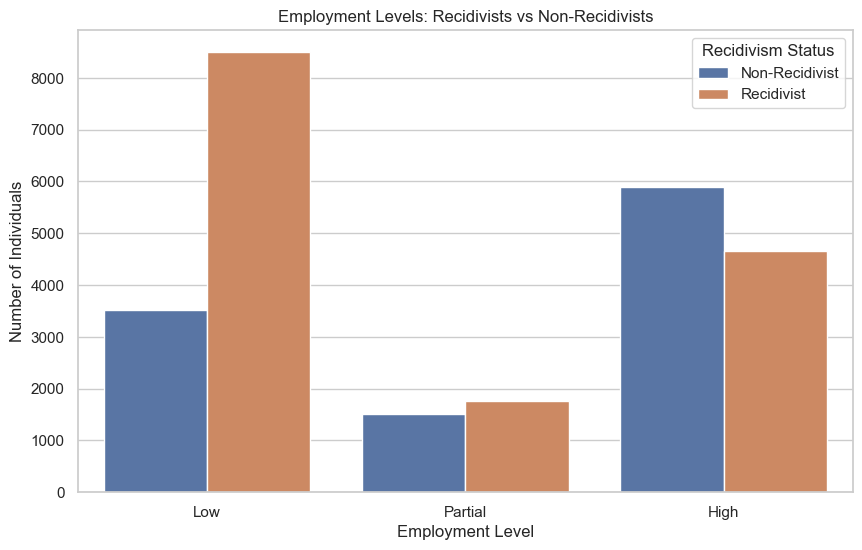

In [22]:
# Categorize employment levels for the whole dataset
df['Employment_Level'] = pd.cut(
    df['Percent_Days_Employed'],
    bins=[-0.01, 0.4, 0.7, 1],
    labels=['Low','Partial','High']
)

#column for recidivism status label
df['Recidivism_Status'] = df['Recidivism_Within_3years'].map({True: 'Recidivist', False: 'Non-Recidivist'})

# Plot side-by-side countplot
plt.figure(figsize=(10,6))
sns.countplot(x='Employment_Level', hue='Recidivism_Status', data=df, order=['Low','Partial','High'])
plt.xlabel('Employment Level')
plt.ylabel('Number of Individuals')
plt.title('Employment Levels: Recidivists vs Non-Recidivists')
plt.legend(title='Recidivism Status')
plt.show()


In [23]:
numeric_features = [
    'Age_at_Release_numeric',
    'Supervision_Risk_Score_First',
    'Dependents_numeric',
    'Percent_Days_Employed',
    'Jobs_Per_Year_numeric'
]

# categorical features
categorical_features = [
    'Gender',
    'Race',
    'Education_Level',
    'Supervision_Level_First',
    'Gang_Affiliated',
    'Employment_Exempt'
]

# Function to get mode of categorical feature
def mode_or_na(series):
    if series.mode().empty:
        return None
    return series.mode()[0]

# Group by cluster
cluster_summary = df.groupby('cluster').agg(
    **{f"{col}_avg": (col, 'mean') for col in numeric_features},
    **{f"{col}_mode": (col, mode_or_na) for col in categorical_features},
    Recidivism_Rate=('Recidivism_Within_3years', 'mean')
).reset_index()

# Map cluster numbers to cluster names
if 'cluster_name' in df.columns:
    cluster_summary['cluster_name'] = cluster_summary['cluster'].map(
        df.set_index('cluster')['cluster_name'].to_dict()
    )

# Reorder columns
cols_order = ['cluster', 'cluster_name'] + \
             [f"{col}_avg" for col in numeric_features] + \
             [f"{col}_mode" for col in categorical_features] + \
             ['Recidivism_Rate']

cluster_summary = cluster_summary[cols_order]

# Display the summary
print(cluster_summary)


   cluster                        cluster_name  Age_at_Release_numeric_avg  \
0        0     Moderate-Risk / High Employment                   31.712495   
1        1         High-Risk / High Employment                   32.792531   
2        2          High-Risk / Low Employment                   30.568253   
3        3  Moderate-Risk / Partial Employment                   33.074250   

   Supervision_Risk_Score_First_avg  Dependents_numeric_avg  \
0                          6.012110                1.647386   
1                          5.877510                1.335934   
2                          6.263661                1.398816   
3                          6.063191                1.558294   

   Percent_Days_Employed_avg  Jobs_Per_Year_numeric_avg Gender_mode Race_mode  \
0                   0.807555                   1.182983           M     BLACK   
1                   0.794549                   1.242640           M     WHITE   
2                   0.045885                   0.1

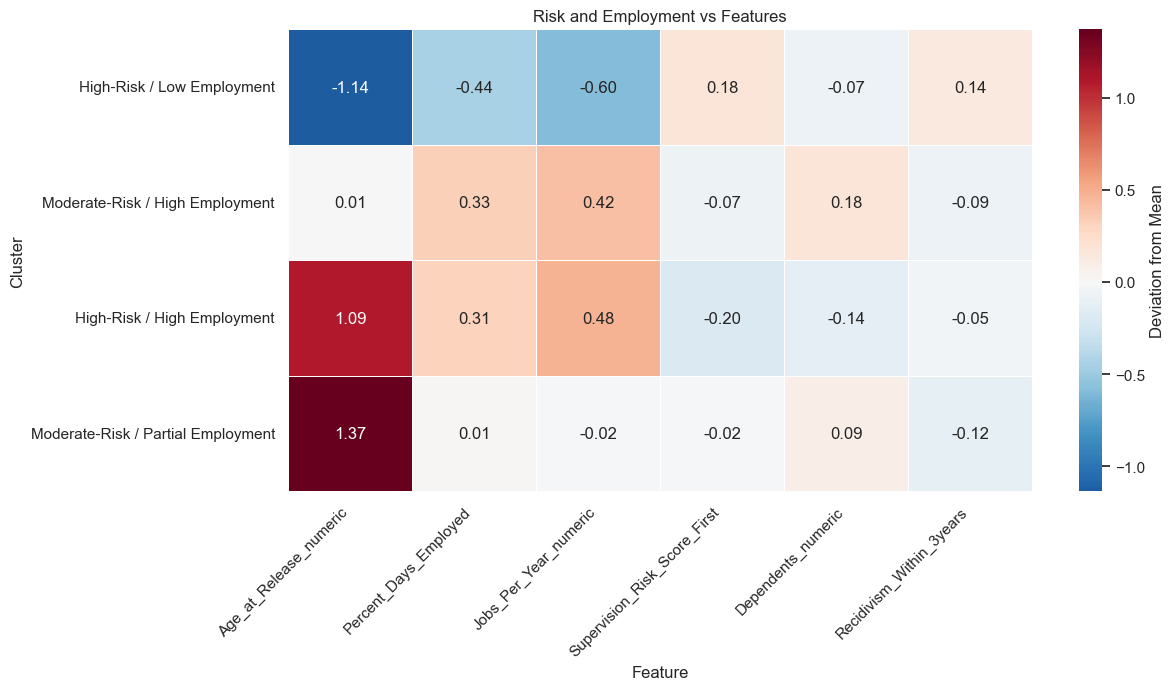

In [24]:
key_features = [
    'Age_at_Release_numeric',
    'Percent_Days_Employed',
    'Jobs_Per_Year_numeric',
    'Supervision_Risk_Score_First',
    'Dependents_numeric',
    'Recidivism_Within_3years'
]

#cluster means
cluster_means = df.groupby('cluster')[key_features].mean()

# Center
cluster_means_centered = cluster_means - df[key_features].mean()

if 'cluster_name' in df.columns:
    cluster_means_centered.index = df.groupby('cluster')['cluster_name'].first()

# Sort clusters by Age
cluster_means_centered = cluster_means_centered.sort_values('Age_at_Release_numeric')

# Plot heatmap
plt.figure(figsize=(12,6))
sns.heatmap(
    cluster_means_centered,
    annot=True,
    cmap='RdBu_r',
    center=0,
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={'label': 'Deviation from Mean'}
)
plt.title("Risk and Employment vs Features")
plt.xlabel("Feature")
plt.ylabel("Cluster")
plt.xticks(rotation=45, ha='right')
plt.show()

In [25]:
#cluster means
cleaned_csv = cluster_means.copy()

if 'cluster_name' in df.columns:
    cleaned_csv.index = df.groupby('cluster')['cluster_name'].first()

cleaned_csv = cleaned_csv.sort_values('Age_at_Release_numeric')
cleaned_csv

,Age_at_Release_numeric,Percent_Days_Employed,Jobs_Per_Year_numeric,Supervision_Risk_Score_First,Dependents_numeric,Recidivism_Within_3years
cluster_name,,,,,,
High-Risk / Low Employment,30.568253,0.045885,0.167190,6.263661,1.398816,0.712445
Moderate-Risk / High Employment,31.712495,0.807555,1.182983,6.012110,1.647386,0.488389
High-Risk / High Employment,32.792531,0.794549,1.242640,5.877510,1.335934,0.527303
Moderate-Risk / Partial Employment,33.074250,0.493171,0.747794,6.063191,1.558294,0.455292


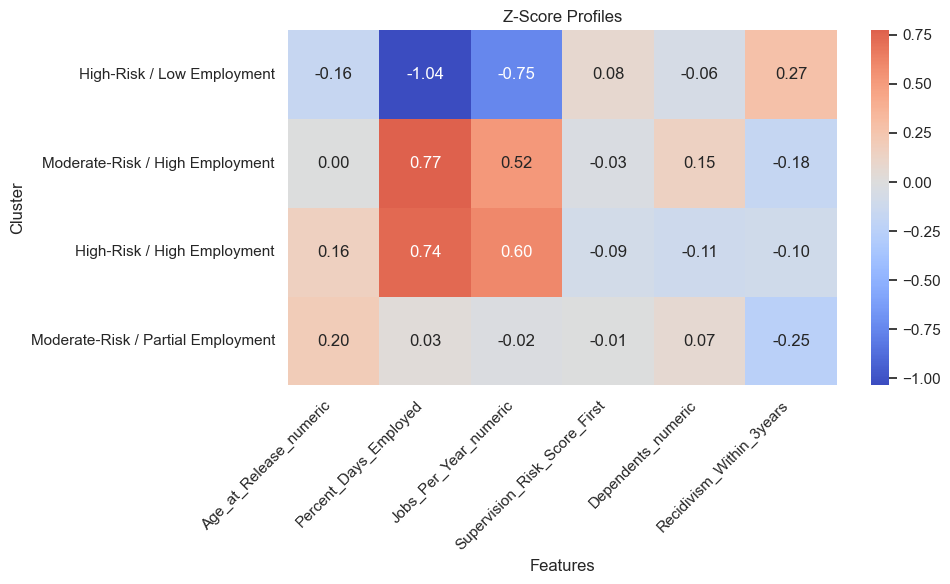

In [26]:
#Z-score normalization
df_z = df.copy()
df_z[key_features] = (df[key_features] - df[key_features].mean()) / df[key_features].std()


#mean z-scores
cluster_std_centered = df_z.groupby('cluster')[key_features].mean()

if 'cluster_name' in df.columns:
    cluster_std_centered.index = df.groupby('cluster')['cluster_name'].first()

cluster_std_centered = cluster_std_centered.sort_values('Age_at_Release_numeric')

plt.figure(figsize=(10, 6))
sns.heatmap(
    cluster_std_centered,
    annot=True,
    cmap='coolwarm',
    center=0,
    fmt=".2f"
)

plt.title("Z-Score Profiles")
plt.xlabel("Features")
plt.ylabel("Cluster")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Data Interpretation

The exploratory data analysis displayed some key distribution across various features; primarily the age, employment, and dependents provided notable information about the potential for recidivism within a 3 year period. The PCA projections provided a preliminary understanding of relationships within a 2-dimensional space.
The K-means clustering further discovered four distinct subgroups within the dataset. The clusters were profiled based upon a few key features: Age, percentage employed, jobs per year, supervision risk, dependents, and recidivism within 3 years. The heatmaps of these cluster groups examined the deviations from the mean populations within the data set The use of the processed z-scores allows for a cleaner comparison of the clusters across the standardized scale, and highlights how significant a deviation of the cluster may be; for example, within the dataset `High-Risk/Low Employment` there is a notable z-score of -0.16 for `Age_at_Release` indicating a slightly younger population.
Given the standardized data that was established it can be seen that the cluster with severe negative deviations of employment display higher recidivism raters, whist high employment experiences a reduced rate.

## Conclusion

This data analysis demonstrates that employment is a critical protective factor that can combat recidivism. KMeans clustering, combined with Z-score normalization makes it possible to identify high-risk, low-employment subgroups that could be prioritized for intervention. Given further data such as more detailed arrrest records implementing targeted employment programs for these at-risk individuals may reduce recidivism rates and improve reintegration outcomes. These findings provide actionable insights for policymakers and rehabilitation programs, showing that data-driven clustering can reveal latent patterns to guide interventions.